In [ ]:
import os
from six.moves import urllib

DATA_URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
DATA_PATH = "data"

def fetch_data(data_url=DATA_URL, data_path=DATA_PATH):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    write_path = os.path.join(data_path, "cifar-10-python.tar.gz")
    urllib.request.urlretrieve(data_url, write_path)
    
file_path = DATA_PATH + "/cifar-10-python.tar.gz"

In [ ]:
# please be patient, the files might take a while to load
fetch_data()

In [ ]:
import tarfile

TarFile = tarfile.open("data/cifar-10-python.tar.gz", mode="r:gz")
TarFile.extractall("data/")

In [ ]:
# After the data has beed downloaded and uncompressed please do not execute the commands above again.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
data_path = "data/cifar-10-batches-py"

In [3]:
# returns a dict with fields: data and labels
def unpickle(file):
    with open(os.path.join(data_path, file), 'rb') as fil:
        dict = pickle.load(fil, encoding="latin1")
    return dict

# recodes the labels from integers (in the range 0 to 9), to vectors of length 10 with a single 1
def one_hot(vec, vals=10):
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [4]:
# Here is a demonstration
one_hot([3,4,1,0,8])

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])

In [5]:
class CifarLoader():
    def __init__(self, source_files):
        self.source = source_files
        self.index = 0
        self.images = None
        self.labels = None
        
    def load(self):
        data = [unpickle(f) for f in self.source]
        images = np.vstack([d["data"] for d in data])
        length = len(images)
        self.images = images.reshape(length, 3, 32, 32).transpose(0, 2, 3, 1).astype(float)/255
        self.labels = one_hot(np.hstack([d["labels"] for d in data]))
        return self
    
    def batch(self, batch_size):
        x, y = self.images[self.index:self.index+batch_size], self.labels[self.index:self.index+batch_size]
        self.index = (self.index + batch_size) % len(self.images)
        return x, y

In [6]:
class CifarDataManager():
    def __init__(self):
        self.train = CifarLoader(["data_batch_{}".format(i) for i in range (1,6)]).load()
        self.test = CifarLoader(["test_batch"]).load()

In [7]:
cifar = CifarDataManager()

In [8]:
# Here is how many 32 x 32 x 3 images we have
print("Number of train images: {}".format(len(cifar.train.images)))
print("Number of test images: {}".format(len(cifar.test.images)))

Number of train images: 50000
Number of test images: 10000


Let's also write a function which will diisplay images in a square: size x size

In [9]:
def DisplayCifar(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    ims = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)]) for j in range(size)])
    plt.imshow(ims)
    plt.show()

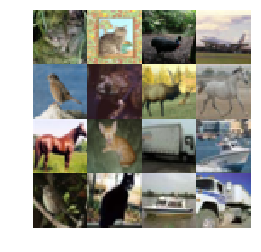

In [10]:
DisplayCifar(cifar.train.images, 4) #Images in a 4x4 box

We are ready to start building the model. It will have three blocks of convolutional layers.

In [11]:
import tensorflow as tf

In [12]:
tf.reset_default_graph()

In [ ]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z)) 

In [13]:
def weight(shape):
    ini = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(ini)

def bias(shape):
    ini = tf.constant(0.1, shape = shape)
    return tf.Variable(ini)

def conv_layer(inpu, shape, strides=[1,1,1,1]):
    W = weight(shape)
    b = bias([shape[3]])
    return tf.nn.relu(tf.nn.conv2d(inpu, W, strides=strides, padding="SAME")+b)

def fully_connected(inpu, outpu):
    W = weight([int(inpu.get_shape()[1]), outpu])
    b = bias([outpu])
    return tf.matmul(inpu, W) + b

In [14]:
X = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y = tf.placeholder(tf.float32, shape=[None,10])
keep_prob = tf.placeholder(tf.float32)

In [15]:
#9 convolution layers, 3 pool layers, 4 dropouts

# the first block of convolution layers
conv1_1 = conv_layer(X, shape=[3,3,3,32])
conv1_2 = conv_layer(conv1_1, shape=[3,3,32,32])
conv1_3 = conv_layer(conv1_2, shape=[3,3,32,32])
conv1_pool = tf.nn.max_pool(conv1_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
conv1_drop = tf.nn.dropout(conv1_pool, keep_prob=keep_prob)

# the second block of convolution layers
conv2_1 = conv_layer(conv1_drop, shape=[3,3,32,64])
conv2_2 = conv_layer(conv2_1, shape=[3,3,64,64])
conv2_3 = conv_layer(conv2_2, shape=[3,3,64,64])
conv2_pool = tf.nn.max_pool(conv2_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
conv2_drop = tf.nn.dropout(conv2_pool, keep_prob=keep_prob)

# the third block of convolution layers
conv3_1 = conv_layer(conv2_drop, shape=[3,3,64,128])
conv3_2 = conv_layer(conv3_1, shape=[3,3,128,128])
conv3_3 = conv_layer(conv3_2, shape=[3,3,128,128])
conv3_pool = tf.nn.max_pool(conv3_3, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
conv3_drop = tf.nn.dropout(conv3_pool, keep_prob=keep_prob)

#ready for fully_connected
conv3_flat = tf.reshape(conv3_pool, [-1, 4*4*128])
conv3_drop = tf.nn.dropout(conv3_flat, keep_prob = keep_prob)
full1 = selu(fully_connected(conv3_flat, 512))
full1_drop = tf.nn.dropout(full1,keep_prob=keep_prob)

# And finally the logits
y_conv = fully_connected(full1_drop, 10)

In [16]:
xentropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y))
train = tf.train.AdamOptimizer(1e-4).minimize(xentropy)

In [17]:
correct = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [18]:
steps = 200000 #It takes many steps to converge
batch_size = 50

final_accuracy = 0
saver = tf.train.Saver()

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(steps):
        batch = cifar.train.batch(batch_size)
        sess.run(train, feed_dict={X: batch[0], y: batch[1], keep_prob: 0.5})
        
        if (i+1) % 5000 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={X: batch[0], y: batch[1], keep_prob: 1.0})
            test_accuracy = sess.run(accuracy, feed_dict={X: cifar.test.images, y: cifar.test.labels, keep_prob: 1.0})
            print("Step {}, \tTraining accuracy {:.4f}, \tTest accuracy {:.4f}".format((i+1), train_accuracy, test_accuracy))
            
            if test_accuracy > final_accuracy:
                final_accuracy = test_accuracy
                save_model = saver.save(sess, "models/cifar_final.ckpt")
    
    print("\nFinal Accuracy {}".format(final_accuracy))

Step 5000, 	Training accuracy 0.2400, 	Test accuracy 0.3255
Step 10000, 	Training accuracy 0.3400, 	Test accuracy 0.4334
Step 15000, 	Training accuracy 0.4800, 	Test accuracy 0.5313
Step 20000, 	Training accuracy 0.5000, 	Test accuracy 0.5760
Step 25000, 	Training accuracy 0.5800, 	Test accuracy 0.6271
Step 30000, 	Training accuracy 0.6800, 	Test accuracy 0.6509
Step 35000, 	Training accuracy 0.6600, 	Test accuracy 0.6808
Step 40000, 	Training accuracy 0.7000, 	Test accuracy 0.7126
Step 45000, 	Training accuracy 0.7200, 	Test accuracy 0.7156
Step 50000, 	Training accuracy 0.7400, 	Test accuracy 0.7410
Step 55000, 	Training accuracy 0.8200, 	Test accuracy 0.7449
Step 60000, 	Training accuracy 0.8400, 	Test accuracy 0.7618
Step 65000, 	Training accuracy 0.7800, 	Test accuracy 0.7679
Step 70000, 	Training accuracy 0.8000, 	Test accuracy 0.7657
Step 75000, 	Training accuracy 0.8000, 	Test accuracy 0.7788
Step 80000, 	Training accuracy 0.8600, 	Test accuracy 0.7756
Step 85000, 	Training acc

Let's display a random test image, together with the true and the predicted classifications

INFO:tensorflow:Restoring parameters from models/cifar_final.ckpt
6353


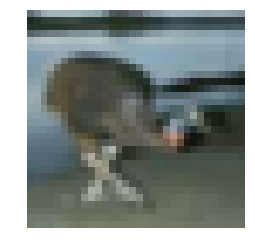

True label [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.] 
Predicted probabilities ['0.1485', '0.0004', '0.4473', '0.2271', '0.0001', '0.0010', '0.1687', '0.0000', '0.0067', '0.0001']


In [20]:
with tf.Session() as sess:
    saver.restore(sess, "models/cifar_final.ckpt")
    index=np.random.randint(0, cifar.test.images.shape[0])
    print(index)
    
    true_label = cifar.test.labels[index]
    pred_prob = sess.run(tf.nn.softmax(y_conv), feed_dict={X: np.expand_dims(cifar.test.images[index], axis=0), keep_prob: 1.0})
    
    plt.figure()
    plt.gca().set_axis_off()
    plt.imshow(cifar.test.images[index])
    plt.show()
    
    print("True label {}".format(true_label), "\nPredicted probabilities", ["{:.4f}".format(i) for i in pred_prob[0, :]])